In [2]:
# import the necessary packages
from collections import deque
from imutils.video import VideoStream
from matplotlib import pyplot as plt
from skimage import morphology

import math
import numpy as np
import argparse
import cv2
import imutils
import time

In [3]:
## Helper Functions for displaying image and scaling
def scale_img(img, scale_percent):
    #print("\nscale_img()")
    #print(img.shape)
    
    # Scaled Image Dimensions
    width  = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    
    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    #print(img.shape)
    return img

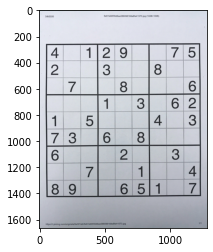

In [4]:
## Read in a File
frame = cv2.imread('sample3.jpg', cv2.IMREAD_COLOR) # Read the file
sf = 50/100 # scaling factor for image
scaled = scale_img(frame, sf*100)
rgb = cv2.cvtColor(scaled, cv2.COLOR_BGR2RGB)
plt.imshow(scaled)
plt.show()

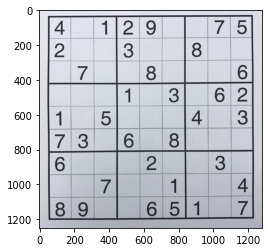

In [5]:
## Crop the image (1)
# crop_img = frame[y:y+h, x:x+w].copy()
crop_img = scaled[ int(sf*450):int(sf*2950), int(sf*5):int(sf*2900) ].copy()
plt.imshow(crop_img)
plt.show()

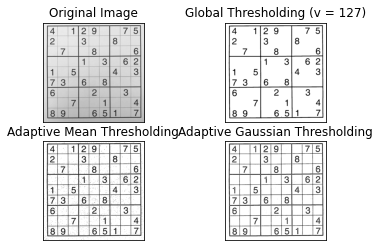

In [6]:
# Convert to Binary
# https://techtutorialsx.com/2019/04/13/python-opencv-converting-image-to-black-and-white/
gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.medianBlur(gray,5)

ret, th1 = cv2.threshold(blurred, 127, 255, cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
th3 = cv2.adaptiveThreshold(blurrcved, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
         'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [gray, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1), plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])
    
plt.show()
#gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#(thresh, binary) = cv2.threshold(gray, 175, 255, cv2.THRESH_BINARY)
#edgeMap = imutils.auto_canny(gray)
#plt.imshow(binary, cmap='gray')
#plt.show()

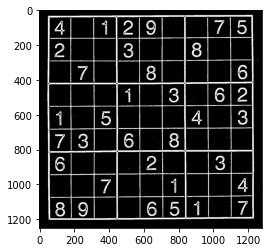

In [7]:
# Remove Noise
# https://scikit-image.org/docs/0.9.x/api/skimage.morphology.html#remove-small-objects
cleaned = morphology.remove_small_objects(th3, min_size=64, connectivity=1)
invert = (255-cleaned)

plt.imshow(invert,cmap='gray')
plt.show()

<class 'numpy.ndarray'>
49
[[  51 1203]
 [  45   32]
 [1227   27]
 [1232 1198]]
(1250, 1278, 3)


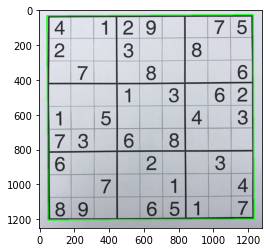

In [32]:
# find contours in the mask and draw largest enclosing rect
cnts = cv2.findContours(invert.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None

contour = crop_img

print(type(cnts[0]))
print(len(cnts))
#for c in cnts:
if len(cnts) > 0:
    #index = cnts.index(max(cnts, key=cv2.contourArea))
    #print(index)
    #cnts.pop(index)
    c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(contour, [box], 0,(0,255,0),5)

print(box)
print(crop_img.shape)
plt.imshow(contour)

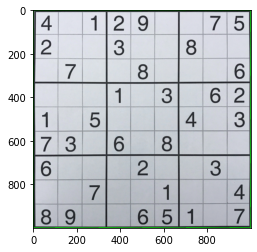

In [45]:
# casts box to right data type
box_32 = np.float32(box)
# desired coord frame
dst = np.float32(np.asarray( [[0,1000],[0,0],[1000,0],[1000,1000]] ))
# transformation matrix
M = cv2.getPerspectiveTransform(box_32, dst)
# corrected image
warped = cv2.warpPerspective(crop_img, M, (1000, 1000))
plt.imshow(warped)
# print(M)

<class 'numpy.ndarray'>
1


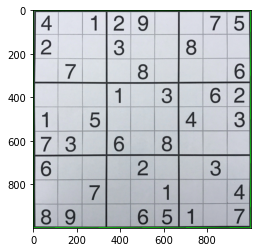

In [49]:
# find contours in the mask and draw largest enclosing rect
warped_gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
cnts = cv2.findContours(warped_gray.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
center = None

contour = crop_img

print(type(cnts[0]))
print(len(cnts))
for c in cnts:
#if len(cnts) > 0:
    #index = cnts.index(max(cnts, key=cv2.contourArea))
    #print(index)
    #cnts.pop(index)
    #c = max(cnts, key=cv2.contourArea)
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(warped, [box], 0,(0,255,0),5)

plt.imshow(warped)